In [2]:
%pip install datasets
%pip install python-dotenv


In [3]:
""" # It's not working!

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from dotenv import load_dotenv

TRAIN_SIZE = 100
VAL_SIZE = 10
BATCH_SIZE = 8

torch.manual_seed(1)
load_dotenv()

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor()
])
transform_validation = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])

def check_range(tensor):
    return (tensor.min() >= 0) and (tensor.max() <= 1)

def prepare_dataset(train_size=10,test_size=10,batch_size=8):
    login_token = os.getenv('HUGGING_FACE_TOKEN')
    dataset_train = load_dataset("imagenet-1k",split='train',use_auth_token=login_token,streaming=True)
    dataset_validation = load_dataset("imagenet-1k",split='test',use_auth_token=login_token,streaming=True)

    # map resize transformation before take
    transformed_train = dataset_train.map(lambda x: {'image': transform_train(x['image']), 'grayscale_image': transform_validation(x['image']),'label': torch.tensor(x['label'])})
    transformed_test = dataset_validation.map(lambda x: {'image': transform_validation(x['image']),'label': torch.tensor(x['label'])})

    # shuffle train dataset
    transformed_train = transformed_train.shuffle()

    print("Dataset loaded successfully")
    return transformed_train.take(train_size),transformed_test.take(test_size)

class RecreationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        return {'image': image}

def prepare_dataloader(train_data,test_data,batch_size=4):

    # prepare data loader
    list_train_data = list(train_data)
    # filter out 1 channel images
    train_data = list(filter(lambda x: x['image'].shape[0] == 3, list_train_data))

    colorization_dataset_train = RecreationDataset(train_data)
    colorization_dataloader_train = DataLoader(colorization_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

    colorization_dataset_validation = RecreationDataset(list(test_data), test=True)
    colorization_dataloader_validation = DataLoader(colorization_dataset_validation, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Data loader prepared successfully")
    return colorization_dataloader_train, colorization_dataloader_validation

train_data, validation_data = prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE)
train_loader, validation_loader = prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)
 """

' # It\'s not working!\n\nfrom datasets import load_dataset\nfrom torch.utils.data import Dataset, DataLoader\nfrom PIL import Image\nfrom dotenv import load_dotenv\n\nTRAIN_SIZE = 100\nVAL_SIZE = 10\nBATCH_SIZE = 8\n\ntorch.manual_seed(1)\nload_dotenv()\n\ntransform_train = torchvision.transforms.Compose([\n    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),\n    torchvision.transforms.ToTensor() \n])\ntransform_validation = torchvision.transforms.Compose([\n    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),\n    torchvision.transforms.ToTensor(),\n])\n\ndef check_range(tensor):\n    return (tensor.min() >= 0) and (tensor.max() <= 1)\n\ndef prepare_dataset(train_size=10,test_size=10,batch_size=8):\n    login_token = os.getenv(\'HUGGING_FACE_TOKEN\')\n    dataset_train = load_dataset("imagenet-1k",split=\'train\',use_auth_token=login_token,streaming=True)\n    dataset_validation = load_dataset("imagenet-1k",split=\'test\',use_auth_toke

In [16]:
import torch
import torchvision
import torch.nn as nn
from IPython.display import Markdown, display
from tqdm import tqdm
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("src/")

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Device: {device}")


Device: cuda


In [5]:
#import os
#from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Create a folder in the root directory
#!mkdir -p "/content/drive/My Drive/CV-19-03-2024"


#gdrive_path = '/content/drive/My Drive/CV-19-03-2024'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
TRAIN_SIZE = 1000
VAL_SIZE = 100
BATCH_SIZE = 64
import imp, dataset
imp.reload(dataset)
#from dataset import prepare_dataset, prepare_dataloader

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE)
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)

Dataset loaded successfully
Data loader prepared successfully


In [48]:
class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)


    def forward(self,x):
        x=x.to(device)
        # Encoder
        conv1 = self.conv1(x)
        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)
        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)

        # Decoder
        concatenation_5to6 = torch.cat((conv4, self.conv_transpose_5to6(conv5)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        concatenation_6to7 = torch.cat((conv3, self.conv_transpose_6to7(conv6)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        concatenation_7to8 = torch.cat((conv2, self.conv_transpose_7to8(conv7)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        concatenation_8_to9 = torch.cat((conv1, self.conv_transpose8to9(conv8)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return output

    def train_model(self, train_loader, val_loader, epochs=10, lr=0.001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True, save_path = "./model_storage/", save_name_prefix='/'):

        '''
        save_path = folder for saving results
        save_name_prefix = prefix for saved files to mark experiments (start with '/')


        '''


        loss_df = pd.DataFrame(['training_loss', 'validation_loss'])
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)

        #for saving progress
        best_val_loss = 99999
        val_loss_list = []
        training_loss_list = []

        for epoch in tqdm(range(epochs)):
            training_loss = 0
            for i, batch_data in enumerate(train_loader):
                image = batch_data['image']
                image = image.to(device)
                optimizer.zero_grad()
                reproduced_image = self(image)
                reproduced_image = reproduced_image.to(device)
                loss = loss_fn(reproduced_image, image)
                training_loss += loss.item()
                loss.backward()
                optimizer.step()

            #average training loss
            training_loss /= len(train_loader)
            training_loss_list.append(training_loss)


            if (epoch)%5 == 0 or (epoch + 1) == epochs:
                val_loss = 0.0  # Track validation loss
                with torch.no_grad():  # Disable gradient calculation for validation
                    for val_data in val_loader:
                        val_image = val_data['image']
                        val_image = val_image.to(device)

                        val_reproduced_image = self(val_image)
                        val_reproduced_image = val_reproduced_image.to(device)

                        val_loss += loss_fn(val_reproduced_image, val_image).item()

                val_loss /= len(val_loader)  # Calculate average validation loss
                val_loss_list.append(val_loss)

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {training_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")


                if val_loss < best_val_loss:  # Update best validation loss and save checkpoint if best model
                  state_diction = self.state_dict()
                  best_val_loss = val_loss
                  for key in state_diction.keys():
                      state_diction[key] = state_diction[key].to(torch.device('cpu'))
                  torch.save(state_diction, (save_path+save_name_prefix+f"UNet_best_model.pth.tar"))

                #construct df with losses
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  'training_loss':training_loss_list, 'val_loss': val_loss_list})
                loss_df.to_csv(save_path+save_name_prefix+"UNet_loss.csv", index=False)
                # plot losses
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['val_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()

                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'UNet_loss_plot.png')
                plt.clf()
            else:
              val_loss_list.append(np.nan)


net=UNet()

In [49]:
net.train_model(train_loader=train_loader, val_loader=validation_loader, epochs=50, lr=0.001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True, save_path= gdrive_path, save_name_prefix='/1000_training_')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0, training_loss = 0.3632462564855814
Epoch 0: validation loss = 0.25210538506507874


 10%|█         | 5/50 [01:08<10:04, 13.43s/it]

Epoch 5, training_loss = 0.031468949920963496
Epoch 5: validation loss = 0.016085346695035696


 20%|██        | 10/50 [02:17<09:11, 13.79s/it]

Epoch 10, training_loss = 0.0029981057086843066
Epoch 10: validation loss = 0.0037214847980067134


 30%|███       | 15/50 [03:27<08:02, 13.80s/it]

Epoch 15, training_loss = 0.0024788996670395136
Epoch 15: validation loss = 0.0026274590054526925


 40%|████      | 20/50 [04:37<06:56, 13.88s/it]

Epoch 20, training_loss = 0.0019417914736550301
Epoch 20: validation loss = 0.0021032766671851277


 50%|█████     | 25/50 [05:49<05:51, 14.06s/it]

Epoch 25, training_loss = 0.0018398136671748944
Epoch 25: validation loss = 0.0020259664161130786


 62%|██████▏   | 31/50 [07:15<04:31, 14.30s/it]

Epoch 30, training_loss = 0.0014463023362623062
Epoch 30: validation loss = 0.002313642529770732


 70%|███████   | 35/50 [08:11<03:31, 14.13s/it]

Epoch 35, training_loss = 0.0015995252069842536
Epoch 35: validation loss = 0.0020053208572790027


 80%|████████  | 40/50 [09:23<02:21, 14.15s/it]

Epoch 40, training_loss = 0.001356219632725697
Epoch 40: validation loss = 0.0015315046184696257


 92%|█████████▏| 46/50 [10:49<00:57, 14.38s/it]

Epoch 45, training_loss = 0.0011424220720073208
Epoch 45: validation loss = 0.00159838842228055


100%|██████████| 50/50 [11:47<00:00, 14.15s/it]

Epoch 49, training_loss = 0.0012976786711078603
Epoch 49: validation loss = 0.0017863106913864613


<Figure size 640x480 with 0 Axes>

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
L shape torch.Size([128, 128])


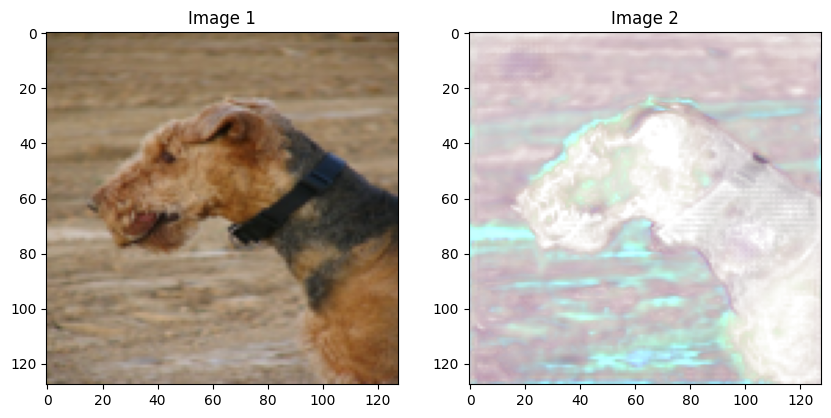

In [50]:
import matplotlib.pyplot as plt

def plot_both(image1,image2):
    plt.figure(figsize=(10, 5))

    # Plot first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.show()


def compose_output(original_image, recreated_image):
    print(original_image.shape)
    print(recreated_image.shape)
    l = original_image[0,:,:]
    print("L shape",l.shape)
    return torch.cat((l.unsqueeze(0),recreated_image),0)

def visualize(image,model):
    output = model(image.unsqueeze(0).to(device))
    output = output.detach().cpu()
    output = compose_output(image,output[0])

    plot_both(image.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())

visualize(list(train_data)[17]['image'],net)